In [1]:
#import sys
#sys.path.append('/home/itsara/env/lib/python2.7/site-packages')

import numpy as np
import pandas as pd
import math
import itertools
from sklearn import preprocessing
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import keras
import matplotlib.pyplot as plt2
from keras.callbacks import ModelCheckpoint
import h5py

from keras.models import load_model

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df["mv close"] = df.close
df.drop(['volume','close'], 1, inplace=True)
df.head()

,symbol,open,low,high,mv close
date,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,114.970001


In [3]:
symbols = list(set(df.symbol))
symbols[:5]

['DHI', 'PNW', 'DTE', 'CMA', 'PNR']

In [4]:
SYM = 'BXP'
df = df[df.symbol == SYM]
df.drop(['symbol'],1,inplace=True)
df.head()

,open,low,high,mv close
date,,,,
2010-01-04,67.589996,66.529999,68.330002,67.099998
2010-01-05,67.239998,66.449997,68.199997,68.120003
2010-01-06,68.230003,68.029999,68.940002,68.440002
2010-01-07,68.260002,67.709999,69.389999,68.739998
2010-01-08,68.260002,67.089996,68.639999,67.849998


In [5]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
#    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['mv close'] = min_max_scaler.fit_transform(df['mv close'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.head()

,open,low,high,mv close
date,,,,
2010-01-04,0.066683,0.061155,0.063825,0.056049
2010-01-05,0.062447,0.060182,0.062259,0.068450
2010-01-06,0.074428,0.079392,0.071171,0.072340
2010-01-07,0.074791,0.075502,0.076590,0.075988
2010-01-08,0.074791,0.067963,0.067558,0.065167


In [6]:
def load_data(stock, seq_len):
    n_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1
    result = []
    
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]

    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_features))  

    return [x_train, y_train, x_test, y_test]

In [7]:
n_features = 4
prev_days = 7
X_train, y_train, X_test, y_test = load_data(df, prev_days)
print (X_train[0], y_train[0])

[[0.06668273 0.061155   0.06382469 0.05604858]
 [0.062447   0.06018233 0.06225912 0.06844986]
 [0.07442818 0.07939209 0.07117055 0.07234042]
 [0.07479123 0.07550151 0.07658959 0.07598779]
 [0.07479123 0.06796348 0.0675578  0.06516712]
 [0.07333894 0.07525838 0.06852121 0.0690577 ]
 [0.06813502 0.06334345 0.06093445 0.06079022]] 0.07428566294398786


In [8]:
def build_model(layers):
    p = 0.25
    model = Sequential()

    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(p))

    model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(p))

    model.add(Dense(64,activation='relu'))
    model.add(Dense(1,activation='linear'))

    model.compile(loss='mse',optimizer='adagrad', metrics=['mse'])

    return model

model = build_model([n_features, prev_days, 1])

In [9]:
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='auto')

model.fit(X_train, y_train, batch_size = 64, epochs = 100, validation_split = 0.1, verbose=1, callbacks=[checkpoint])

model.load_weights("weights.best.hdf5")
model.compile(loss='mse',optimizer='adagrad', metrics=['mse'])

Train on 1421 samples, validate on 158 samples
Epoch 1/100
1421/1421 [==============================] - 2s 1ms/step - loss: 0.0496 - mean_squared_error: 0.0496 - val_loss: 0.0062 - val_mean_squared_error: 0.0062

Epoch 00001: val_mean_squared_error improved from inf to 0.00623, saving model to weights.best.hdf5
Epoch 2/100
1421/1421 [==============================] - 1s 370us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0014 - val_mean_squared_error: 0.0014

Epoch 00002: val_mean_squared_error improved from 0.00623 to 0.00136, saving model to weights.best.hdf5
Epoch 3/100
1421/1421 [==============================] - 1s 390us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0020 - val_mean_squared_error: 0.0020

Epoch 00003: val_mean_squared_error did not improve
Epoch 4/100
1421/1421 [==============================] - 1s 403us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0134 - val_mean_squared_error: 0.0134

Epoch 00004: val_mean_squar

1421/1421 [==============================] - 1s 500us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0068 - val_mean_squared_error: 0.0068

Epoch 00074: val_mean_squared_error did not improve
Epoch 75/100
1421/1421 [==============================] - 1s 463us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0027 - val_mean_squared_error: 0.0027

Epoch 00075: val_mean_squared_error did not improve
Epoch 76/100
1421/1421 [==============================] - 1s 495us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0085 - val_mean_squared_error: 0.0085

Epoch 00076: val_mean_squared_error did not improve
Epoch 77/100
1421/1421 [==============================] - 1s 454us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0037 - val_mean_squared_error: 0.0037

Epoch 00077: val_mean_squared_error did not improve
Epoch 78/100
1421/1421 [==============================] - 1s 452us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0

In [10]:
diff=[]
ratio=[]
predict = model.predict(X_test)
for d in range(len(y_test)):
    pred = predict[d][0]
    ratio.append((y_test[d]/pred)-1)
    diff.append(abs(y_test[d]- pred))

In [11]:
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df["mv close"] = df.close
df.drop(['volume', 'close'], 1, inplace=True)
df = df[df.symbol == SYM]
df.drop(['symbol'],1,inplace=True)

def denormalize(df, normalized_value): 
    df = df['mv close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)

    min_max_scaler = preprocessing.MinMaxScaler()
    _ = min_max_scaler.fit_transform(df)
    denorm = min_max_scaler.inverse_transform(normalized_value)
    return denorm

new_pred = denormalize(df, predict)
newy_test = denormalize(df, y_test)

In [12]:
def evaluation(model, X_test, y_test):
    score = model.evaluate(X_test, y_test, verbose=0)
    print('MSE: %.5f (RMSE: %.2f)' % (score[0], math.sqrt(score[0])))
    return score[0], math.sqrt(score[0])

evaluation(model, X_test, y_test)

MSE: 0.00153 (RMSE: 0.04)


(0.0015323527077479022, 0.03914527695326605)

Sell [130.550003]
Balance: [100000.]
Buy [128.860001]
Buy [131.110001]
Sell [129.940002]
Balance: [84998.6434996]
Sell [130.580002]
Balance: [88766.09117619]
Sell [130.860001]
Balance: [91597.73575714]
Buy [130.899994]
Buy [132.270004]
Sell [133.130005]
Balance: [78817.15382448]
Sell [130.899994]
Balance: [84141.02004286]
Sell [131.380005]
Balance: [88148.56169174]
Sell [130.059998]
Balance: [91124.01936606]
Sell [130.809998]
Balance: [93368.4812591]
Sell [130.389999]
Balance: [95046.42286408]
Buy [127.25]
Buy [123.709999]
Buy [124.389999]
Buy [124.440002]
Buy [125.860001]
Buy [125.260002]
Buy [124.800003]
Buy [125.410004]
Buy [125.629997]
Sell [127.260002]
Balance: [29147.26235881]
Sell [127.779999]
Balance: [47296.75079667]
Sell [127.059998]
Balance: [60832.1670355]
Sell [127.889999]
Balance: [71050.04282153]
Sell [128.070007]
Balance: [78724.23607554]
Sell [128.979996]
Balance: [84520.77719233]
Sell [128.229996]
Balance: [88842.9034945]
Sell [127.120003]
Balance: [92056.43811376]
Se

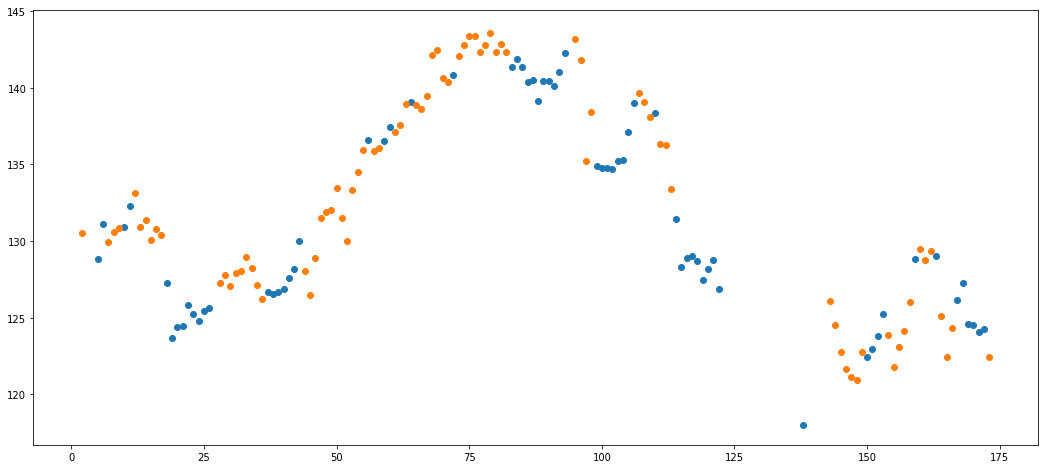

In [13]:
import random
random.seed(1997)

balance = 100000.0
cash_list= []
volume = 0
buyx = []
buyy =[]
selx = []
sely = []
for i in range(2,len(new_pred) - 1):
    prediction = new_pred[i]
    rand = random.randint(1, 100)
    if (prediction > new_pred[i-1] and balance != 0) or rand <= 5:
        if balance <= 10000:
            money = balance
            balance = 0
        else:
            money = 10000
            balance = balance - 10000
        volume += money / newy_test[i]
        buyx.append(i)
        buyy.append(newy_test[i])
        print("Buy " + str(newy_test[i]))
    elif(volume > 0 and prediction < new_pred[i-1] and prediction * 1.002 < new_pred[i-2]) or rand > 95:
        forSell = volume/4.0
        volume = volume*3.0/4.0
        balance += forSell * newy_test[i]
        selx.append(i)
        sely.append(newy_test[i])
        print("Sell " + str(newy_test[i]))
        print("Balance: " + str(balance))

if(volume != 0):
    balance += volume * newy_test[i]
    volume = 0
    selx.append(i)
    sely.append(newy_test[i])
    print("Sell : " + str(newy_test[i]))
    print("Balance : " + str(balance))
    
print("Balance : " + str(balance))
plt2.figure(figsize=(18,8))
plt2.scatter(buyx, buyy)
plt2.scatter(selx, sely)

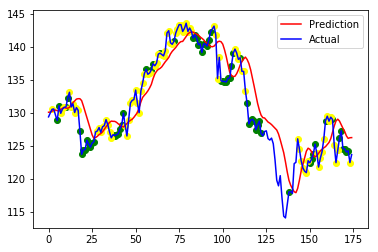

In [15]:
plt2.plot(new_pred,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.scatter(buyx, buyy, color='green')
plt2.scatter(selx, sely, color='yellow')
plt2.show()